In [1]:
import photutils

In [2]:
from photutils import CircularAperture, EPSFBuilder, find_peaks, CircularAnnulus
from photutils.detection import DAOStarFinder, IRAFStarFinder
from photutils.psf import DAOGroup, IntegratedGaussianPRF, extract_stars, IterativelySubtractedPSFPhotometry, BasicPSFPhotometry
from photutils.background import MMMBackground
from photutils.background import MMMBackground, MADStdBackgroundRMS
from astropy.modeling.fitting import LevMarLSQFitter

In [3]:
import numpy as np
from astropy.stats import mad_std
from astropy import stats

In [4]:
from astropy.io import fits
from astropy import wcs
from astropy.table import Table

In [5]:
from photutils.psf import EPSFFitter
from photutils.psf.epsf_stars import extract_stars
from astropy.nddata import NDData

In [6]:
from astropy.convolution import convolve, convolve_fft, Gaussian2DKernel

In [7]:
from astroquery.svo_fps import SvoFps

In [8]:
from astropy import units as u

In [9]:
import os
os.chdir('/orange/adamginsburg/jwst/jw02731/background_estimation/')

In [10]:
import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'

In [11]:
im1 = fits.open('/orange/adamginsburg/jwst/jw02731/L3/t/jw02731-o001_t017_nircam_clear-f444w_i2d.fits')
data = im1[1].data
con = im1[3].data

In [12]:
instrument = im1[0].header['INSTRUME']
telescope = im1[0].header['TELESCOP']
filt = im1[0].header['FILTER']
wavelength_table = SvoFps.get_transmission_data(f'{telescope}/{instrument}.{filt}')
obsdate = im1[0].header['DATE-OBS']

In [13]:
filter_table = SvoFps.get_filter_list(facility=telescope, instrument=instrument)
filter_table.add_index('filterID')
instrument = 'NIRCam'
eff_wavelength = filter_table.loc[f'{telescope}/{instrument}.{filt}']['WavelengthEff'] * u.AA

In [14]:
fwhm = (1.22 * eff_wavelength / (6.5*u.m)).to(u.arcsec, u.dimensionless_angles())
fwhm

<Quantity 0.16842379 arcsec>

In [15]:
ww = wcs.WCS(im1[1].header)
pixscale = ww.proj_plane_pixel_area()**0.5
fwhm_pix = (fwhm / pixscale).decompose().value
fwhm_pix

Set DATE-AVG to '2022-06-03T12:45:26.346' from MJD-AVG.
Set DATE-END to '2022-06-03T15:22:38.772' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.574327 from OBSGEO-[XYZ].
Set OBSGEO-H to 1654444171.915 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.677224740298114

In [16]:
import os
os.environ['WEBBPSF_PATH'] = '/orange/adamginsburg/jwst/webbpsf-data/'
with open(os.path.expanduser('~/.mast_api_token'), 'r') as fh:
    os.environ['MAST_API_TOKEN'] = fh.read().strip()
import webbpsf

In [17]:
os.getenv('MAST_API_TOKEN')

'2f26f48412c944009bd13fb90d56c48c'

In [18]:
import webbpsf
nc = webbpsf.NIRCam()
nc.filter =  'F444W'
nc.load_wss_opd_by_date(f'{obsdate}T00:00:00')
psf = nc.calc_psf(oversample=4, fov_pixels=31)     # returns an astropy.io.fits.HDUlist containing PSF and header


MAST OPD query around UTC: 2022-06-03T00:00:00.000
                        MJD: 59733.0

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022060103-NRCA3_FP1-1.fits
	Date (MJD):	 59731.7095
	Delta time:	 -1.2905 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022060402-NRCA3_FP1-1.fits
	Date (MJD):	 59733.8175
	Delta time:	 0.8175 days
User requested choosing OPD time closest in time to 2022-06-03T00:00:00.000, which is R2022060402-NRCA3_FP1-1.fits, delta time 0.817 days
INFO: MAST API token accepted, welcome Adam Ginsburg [astroquery.mast.auth]
Importing and format-converting OPD from /orange/adamginsburg/jwst/webbpsf-data/MAST_JWST_WSS_OPDs/R2022060402-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point


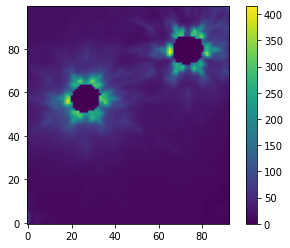

In [19]:
pl.imshow(data[2200:2300,4207:4300], origin='lower')
pl.colorbar()

In [20]:
from scipy.ndimage import label, find_objects, center_of_mass, sum_labels

In [21]:
nrc = webbpsf.NIRCam()
nrc.load_wss_opd_by_date(f'{obsdate}T00:00:00')
nrc.filter =  'F444W'
grid = nrc.psf_grid(num_psfs=16, all_detectors=False)


MAST OPD query around UTC: 2022-06-03T00:00:00.000
                        MJD: 59733.0

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022060103-NRCA3_FP1-1.fits
	Date (MJD):	 59731.7095
	Delta time:	 -1.2905 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022060402-NRCA3_FP1-1.fits
	Date (MJD):	 59733.8175
	Delta time:	 0.8175 days
User requested choosing OPD time closest in time to 2022-06-03T00:00:00.000, which is R2022060402-NRCA3_FP1-1.fits, delta time 0.817 days
Importing and format-converting OPD from /orange/adamginsburg/jwst/webbpsf-data/MAST_JWST_WSS_OPDs/R2022060402-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point

Running instrument: NIRCam, filter: F444W
  Running detector: NRCA5
    Position 1/16: (0, 0) pixels
    Position 2/16: (0, 682) pixels
    Position 3/16: (0, 1365) pixels
    Position 4/16: (0, 2047) pixels
    Position 5/16: (682, 0) pixels
    Position 6/16: (68

big_grid = nrc.psf_grid(num_psfs=16, all_detectors=False, fov_pixels=512)

In [22]:
from scipy import ndimage

In [23]:
from tqdm.notebook import tqdm

In [24]:
from astropy.visualization import simple_norm

In [25]:
%run ../code/starfinding.py

In [26]:
daogroup = DAOGroup(crit_separation=8)

phot = BasicPSFPhotometry(finder=finder_maker(),
                          group_maker=daogroup,
                          bkg_estimator=None, # must be none or it un-saturates pixels
                          psf_model=grid,
                          fitter=LevMarLSQFitter(),
                          fitshape=(101, 101),
                          aperture_radius=5*fwhm_pix)

In [27]:
result = phot(data[1000:2500,1000:2500], mask=ndimage.binary_dilation(data[1000:2500,1000:2500]==0))

0it [00:00, ?it/s]

is_star=15, sizes=18, coms_finite=18, coms_inbounds=15, total=15 candidates


In [28]:
resid = phot.get_residual_image()

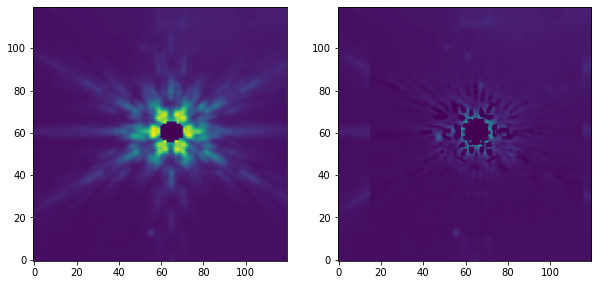

In [29]:
pl.figure(figsize=(10,5))
slc = slice(560,680),slice(830,950)
norm = simple_norm(data[1000:2500,1000:2500][slc], stretch='asinh')
msk = data[1000:2500,1000:2500][slc] != 0
pl.subplot(1,2,1).imshow(data[1000:2500,1000:2500][slc]*msk, origin='lower', norm=norm)
pl.subplot(1,2,2).imshow(resid[slc]*msk, origin='lower', norm=norm)

In [30]:
finder_maker(min_size=100, max_size=200)(data)

0it [00:00, ?it/s]

is_star=9, sizes=9, coms_finite=916, coms_inbounds=853, total=9 candidates


id,xcentroid,ycentroid
int64,float64,float64
1,1528.0679611650485,782.8446601941747
2,5301.345454545454,1063.790909090909
3,4233.343065693431,2257.065693430657
4,4280.145695364238,2279.271523178808
5,6383.824858757062,2562.5649717514125
6,3169.1009174311926,2582.376146788991
7,5311.646464646465,2836.686868686869
8,6630.642857142857,3239.095238095238
9,2586.1102362204724,3659.2755905511813


In [31]:
pwd

'/orange/adamginsburg/jwst/jw02731/background_estimation'

In [32]:
%run ../code/starfinding.py

In [33]:
len(finder_maker(min_size=0, max_size=200, min_flux=500)(data))

0it [00:00, ?it/s]

is_star=301, sizes=909, coms_finite=916, coms_inbounds=853, total=301 candidates


301

In [34]:
from photutils.psf import EPSFModel
epsf_model = EPSFModel(data=fits.getdata('F444W_ePSF_quadratic_filtered-background-subtracted.fits'))

# Fit the background-subtracted data

In [35]:
im1 = fits.open('/orange/adamginsburg/jwst/jw02731/L3/t/jw02731-o001_t017_nircam_clear-f444w_i2d.fits')
origdata = im1[1].data
im2 = fits.open('/orange/adamginsburg/jwst/jw02731/background_estimation/F444W_filter-based-background-subtraction.fits')
data = im2[0].data
print(data.shape, origdata.shape)
data[origdata == 0] = 0

(4179, 7065) (4179, 7065)


In [36]:
data.shape, origdata.shape

((4179, 7065), (4179, 7065))

In [37]:
phot = BasicPSFPhotometry(finder=finder_maker(min_size=100, max_size=200),
                          group_maker=daogroup,
                          bkg_estimator=None, # must be none or it un-saturates pixels
                          #psf_model=epsf_model,
                          psf_model=big_grid,
                          fitter=LevMarLSQFitter(),
                          fitshape=251,
                          aperture_radius=15*fwhm_pix)
brightest_result = phot(data, mask=ndimage.binary_dilation(data==0, iterations=1))

0it [00:00, ?it/s]

is_star=9, sizes=9, coms_finite=991, coms_inbounds=927, total=9 candidates


In [38]:
resid = brightest_resid = phot.get_residual_image()

In [39]:
stars_tbl = Table()
stars_tbl['x'] = brightest_result['x_fit']
stars_tbl['y'] = brightest_result['y_fit']

brightest_stars = extract_stars(NDData(data), stars_tbl, size=251)

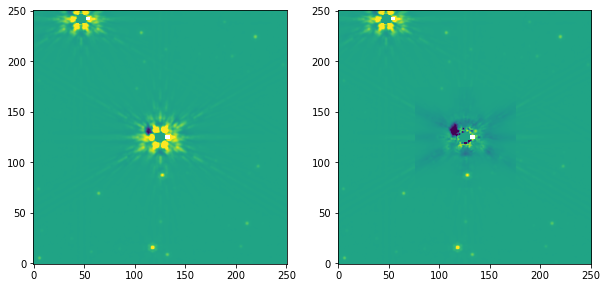

In [40]:
star = brightest_stars[0]

pl.figure(figsize=(10,5))
slc = star.slices
norm = simple_norm(data[slc], stretch='asinh', max_percent=99.5, min_percent=0.001)
msk = data[slc] != 0
pl.subplot(1,2,1).imshow(data[slc]*msk, origin='lower', norm=norm)
pl.subplot(1,2,2).imshow(resid[slc]*msk, origin='lower', norm=norm)

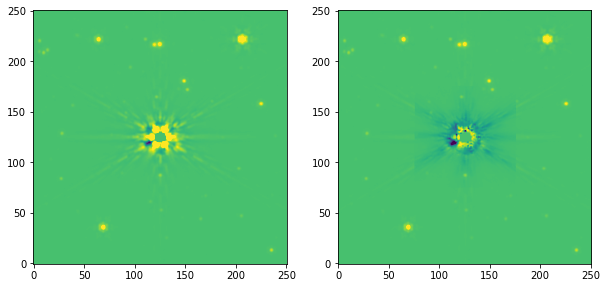

In [41]:
star = brightest_stars[1]

pl.figure(figsize=(10,5))
slc = star.slices
norm = simple_norm(data[slc], stretch='asinh', max_percent=99.5, min_percent=0.001)
msk = data[slc] != 0
pl.subplot(1,2,1).imshow(data[slc]*msk, origin='lower', norm=norm)
pl.subplot(1,2,2).imshow(resid[slc]*msk, origin='lower', norm=norm)

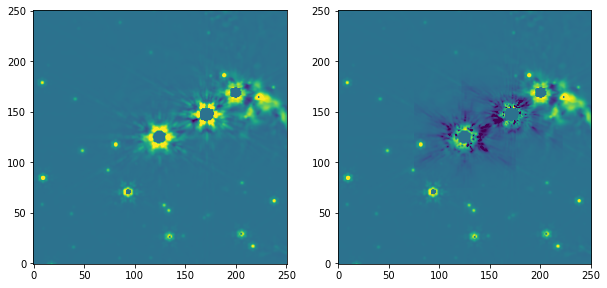

In [42]:
star = brightest_stars[2]

pl.figure(figsize=(10,5))
slc = star.slices
norm = simple_norm(data[slc], stretch='asinh', max_percent=99.5, min_percent=0.001)
msk = data[slc] != 0
pl.subplot(1,2,1).imshow(data[slc]*msk, origin='lower', norm=norm)
pl.subplot(1,2,2).imshow(resid[slc]*msk, origin='lower', norm=norm)

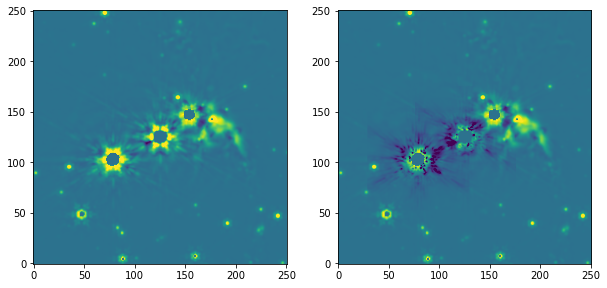

In [43]:
star = brightest_stars[3]

pl.figure(figsize=(10,5))
slc = star.slices
norm = simple_norm(data[slc], stretch='asinh', max_percent=99.5, min_percent=0.001)
msk = data[slc] != 0
pl.subplot(1,2,1).imshow(data[slc]*msk, origin='lower', norm=norm)
pl.subplot(1,2,2).imshow(resid[slc]*msk, origin='lower', norm=norm)

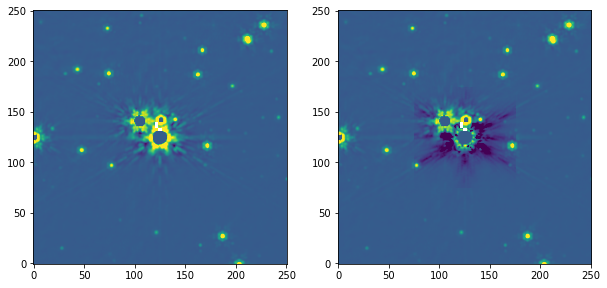

In [44]:
star = brightest_stars[4]

pl.figure(figsize=(10,5))
slc = star.slices
norm = simple_norm(data[slc], stretch='asinh', max_percent=99.5, min_percent=0.001)
msk = data[slc] != 0
pl.subplot(1,2,1).imshow(data[slc]*msk, origin='lower', norm=norm)
pl.subplot(1,2,2).imshow(resid[slc]*msk, origin='lower', norm=norm)

In [45]:
phot = BasicPSFPhotometry(finder=finder_maker(min_size=50, max_size=100),
                          group_maker=daogroup,
                          bkg_estimator=None, # must be none or it un-saturates pixels
                          psf_model=grid,
                          fitter=LevMarLSQFitter(),
                          fitshape=101,
                          aperture_radius=15*fwhm_pix)
next_brightest_result = phot(brightest_resid, mask=ndimage.binary_dilation(data==0, iterations=1))

0it [00:00, ?it/s]

is_star=20, sizes=21, coms_finite=978, coms_inbounds=914, total=20 candidates


In [46]:
next_brightest_resid = resid = phot.get_residual_image()

In [47]:
stars_tbl = Table()
stars_tbl['x'] = next_brightest_result['x_fit']
stars_tbl['y'] = next_brightest_result['y_fit']

next_brightest_stars = extract_stars(NDData(data), stars_tbl, size=251)

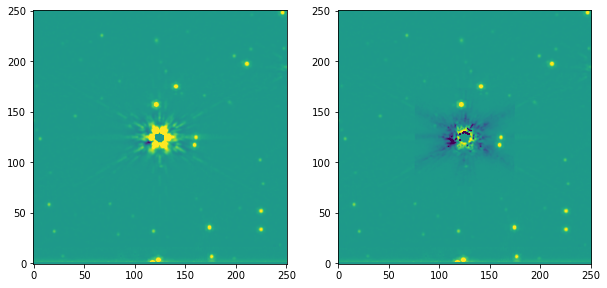

In [48]:
star = next_brightest_stars[0]

pl.figure(figsize=(10,5))
slc = star.slices
norm = simple_norm(data[slc], stretch='asinh', max_percent=99.5, min_percent=0.001)
msk = data[slc] != 0
pl.subplot(1,2,1).imshow(data[slc]*msk, origin='lower', norm=norm)
pl.subplot(1,2,2).imshow(resid[slc]*msk, origin='lower', norm=norm)

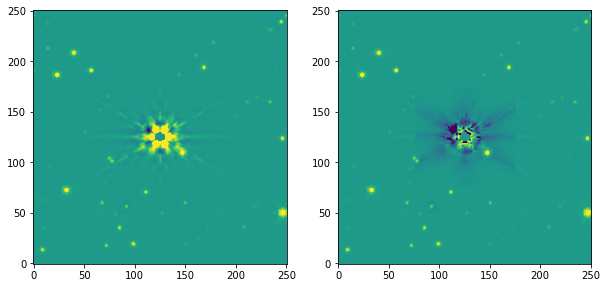

In [49]:
star = next_brightest_stars[1]

pl.figure(figsize=(10,5))
slc = star.slices
norm = simple_norm(data[slc], stretch='asinh', max_percent=99.5, min_percent=0.001)
msk = data[slc] != 0
pl.subplot(1,2,1).imshow(data[slc]*msk, origin='lower', norm=norm)
pl.subplot(1,2,2).imshow(resid[slc]*msk, origin='lower', norm=norm)

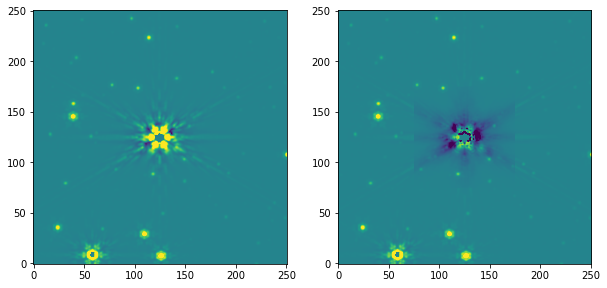

In [50]:
star = next_brightest_stars[2]

pl.figure(figsize=(10,5))
slc = star.slices
norm = simple_norm(data[slc], stretch='asinh', max_percent=99.5, min_percent=0.001)
msk = data[slc] != 0
pl.subplot(1,2,1).imshow(data[slc]*msk, origin='lower', norm=norm)
pl.subplot(1,2,2).imshow(resid[slc]*msk, origin='lower', norm=norm)

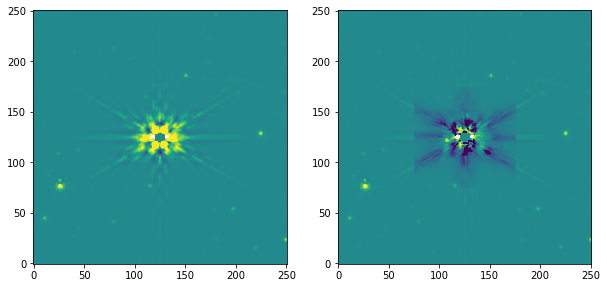

In [51]:
star = next_brightest_stars[5]

pl.figure(figsize=(10,5))
slc = star.slices
norm = simple_norm(data[slc], stretch='asinh', max_percent=99.5, min_percent=0.001)
msk = data[slc] != 0
pl.subplot(1,2,1).imshow(data[slc]*msk, origin='lower', norm=norm)
pl.subplot(1,2,2).imshow(resid[slc]*msk, origin='lower', norm=norm)

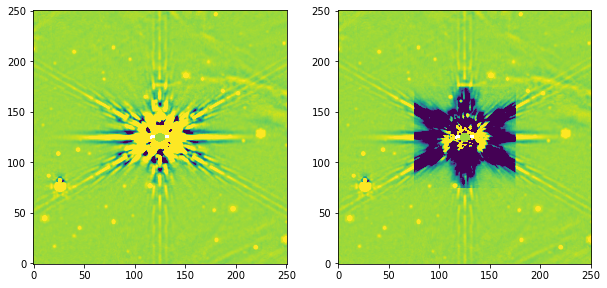

In [52]:
star = next_brightest_stars[5]

pl.figure(figsize=(10,5))
slc = star.slices
norm = simple_norm(data[slc], stretch='asinh', max_percent=95., min_percent=0.5)
msk = data[slc] != 0
pl.subplot(1,2,1).imshow(data[slc]*msk, origin='lower', norm=norm)
pl.subplot(1,2,2).imshow(resid[slc]*msk, origin='lower', norm=norm)

In [53]:
phot = BasicPSFPhotometry(finder=finder_maker(min_size=30, max_size=50),
                          group_maker=daogroup,
                          bkg_estimator=None, # must be none or it un-saturates pixels
                          psf_model=grid,
                          fitter=LevMarLSQFitter(),
                          fitshape=101,
                          aperture_radius=15*fwhm_pix)
third_brightest_result = phot(next_brightest_resid, mask=data==0, )

0it [00:00, ?it/s]

is_star=26, sizes=26, coms_finite=952, coms_inbounds=888, total=26 candidates


In [54]:
third_brightest_resid = resid = phot.get_residual_image()

In [55]:
stars_tbl = Table()
stars_tbl['x'] = third_brightest_result['x_fit']
stars_tbl['y'] = third_brightest_result['y_fit']

third_brightest_stars = extract_stars(NDData(data), stars_tbl, size=251)

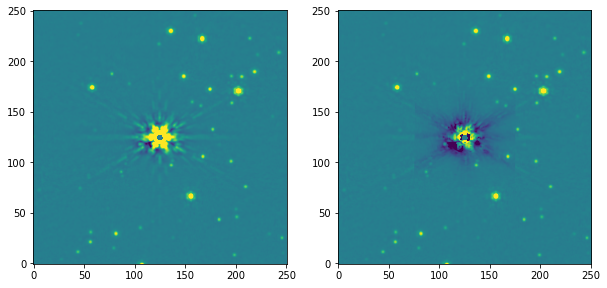

In [56]:
star = third_brightest_stars[0]

pl.figure(figsize=(10,5))
slc = star.slices
norm = simple_norm(data[slc], stretch='asinh', max_percent=99.5, min_percent=0.01)
msk = data[slc] != 0
pl.subplot(1,2,1).imshow(data[slc]*msk, origin='lower', norm=norm)
pl.subplot(1,2,2).imshow(resid[slc]*msk, origin='lower', norm=norm)

In [57]:
phot = BasicPSFPhotometry(finder=finder_maker(min_size=0, max_size=30, min_flux=1000, require_gradient=True),
                          group_maker=daogroup,
                          bkg_estimator=None, # must be none or it un-saturates pixels
                          psf_model=grid,
                          fitter=LevMarLSQFitter(),
                          fitshape=51,
                          aperture_radius=5*fwhm_pix)
fourth_brightest_result = phot(third_brightest_resid, mask=ndimage.binary_dilation(data==0), )

0it [00:00, ?it/s]

is_star=220, sizes=900, coms_finite=915, coms_inbounds=851, total=220 candidates


In [58]:
fourth_brightest_resid = resid = phot.get_residual_image()

In [59]:
stars_tbl = Table()
stars_tbl['x'] = fourth_brightest_result['x_fit']
stars_tbl['y'] = fourth_brightest_result['y_fit']

fourth_brightest_stars = extract_stars(NDData(data), stars_tbl, size=51)

2704.5122

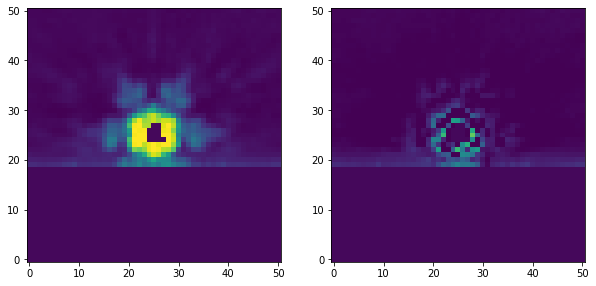

In [60]:
star = fourth_brightest_stars[0]

pl.figure(figsize=(10,5))
slc = star.slices
norm = simple_norm(data[slc], stretch='asinh', max_percent=99.5, min_percent=0.01)
msk = data[slc] != 0
pl.subplot(1,2,1).imshow(data[slc]*msk, origin='lower', norm=norm)
pl.subplot(1,2,2).imshow(resid[slc]*msk, origin='lower', norm=norm)

data[slc][ndimage.binary_dilation(data[slc]==0, iterations=3)].sum()

7857.2236

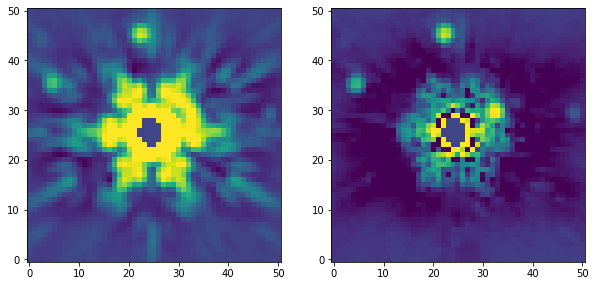

In [61]:
star = fourth_brightest_stars[15]

pl.figure(figsize=(10,5))
slc = star.slices
norm = simple_norm(data[slc], stretch='asinh', max_percent=95., min_percent=0.01)
msk = data[slc] != 0
pl.subplot(1,2,1).imshow(data[slc]*msk, origin='lower', norm=norm)
pl.subplot(1,2,2).imshow(resid[slc]*msk, origin='lower', norm=norm)
data[slc][ndimage.binary_dilation(data[slc]==0, iterations=3)].sum()

1730.5718

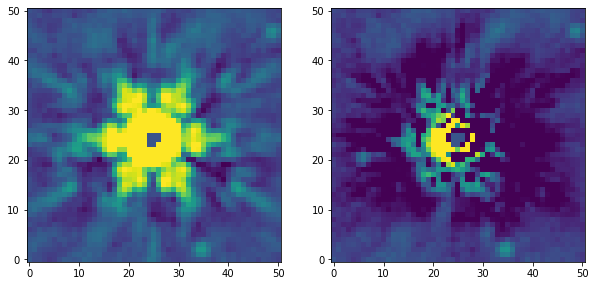

In [62]:
star = fourth_brightest_stars[25]

pl.figure(figsize=(10,5))
slc = star.slices
norm = simple_norm(data[slc], stretch='asinh', max_percent=95, min_percent=0.01)
msk = data[slc] != 0
pl.subplot(1,2,1).imshow(data[slc]*msk, origin='lower', norm=norm)
pl.subplot(1,2,2).imshow(resid[slc]*msk, origin='lower', norm=norm)
data[slc][ndimage.binary_dilation(data[slc]==0, iterations=3)].sum()

In [63]:
from astropy import table

In [ ]:
stacked_star_table = table.vstack([brightest_result, next_brightest_result, third_brightest_result, fourth_brightest_result])
original_resid = photutils.psf.utils.subtract_psf(origdata, grid, stacked_star_table)
fits.PrimaryHDU(data=original_resid, header=im1[1].header).writeto("F444W_saturated_stars_subtracted.fits", overwrite=True)

In [ ]:
print("TEST")

# Below here was test work fitting individual stars

In [ ]:
starlist = finder_maker()(data)
starlist

In [ ]:
x0,y0 = map(int, (starlist['xcentroid'][1], starlist['ycentroid'][1]))
sz = 16
pl.imshow(data[y0-sz:y0+sz, x0-sz:x0+sz], origin='lower')

In [ ]:
epsffitter = EPSFFitter(fit_boxsize=31)

In [ ]:
stars_tbl = Table()
stars_tbl['x'] = starlist['xcentroid']
stars_tbl['y'] = starlist['ycentroid']

stars = extract_stars(NDData(data), stars_tbl, size=31)

In [ ]:
fitter = LevMarLSQFitter()

In [ ]:
star = stars[100]
star.center_flat

In [ ]:
grid.flux = 10050
grid.x_0 = 15.5
grid.y_0 = 15.5

In [ ]:
resid = star.data - grid(xx, yy)
resid[star.data == 0] = np.nan
norm = simple_norm(resid, stretch='asinh', max_percent=95, min_percent=5)
pl.imshow(resid, origin='lower', norm=norm)
pl.colorbar()

In [ ]:
yy, xx = np.indices(star.data.shape, dtype=float)

fitted_epsf = fitter(model=grid, x=xx, y=yy, z=star.data,
                     weights=star.data > 0
                     )
fitted_epsf

In [ ]:
from astropy.visualization import simple_norm
pl.rcParams['figure.facecolor'] = 'w'

In [ ]:
resid = star.data - fitted_epsf(xx, yy)
resid[star.data == 0] = np.nan
norm = simple_norm(resid, stretch='linear', max_percent=99, min_percent=1)
pl.imshow(resid, origin='lower', norm=norm)
pl.colorbar()

In [ ]:
grid

In [ ]:
yy, xx = np.indices(star.data.shape, dtype=float)

data = star.data.copy()
mask = ndimage.binary_dilation(data == 0, iterations=3)
data[mask] = np.nan

grid.x_0 = 15.5
grid.y_0 = 15.5

fitted_epsf = fitter(model=grid, x=xx, y=yy, z=star.data,
                     weights=mask == 0
                     )
fitted_epsf

In [ ]:
resid = star.data - fitted_epsf(xx, yy)
resid[star.data == 0] = np.nan
norm = simple_norm(resid, stretch='linear', max_percent=99, min_percent=1)
pl.figure(figsize=(12,5))
pl.subplot(1,2,1)
pl.imshow(resid, origin='lower', norm=norm)
pl.colorbar()
pl.subplot(1,2,2)
norm = simple_norm(resid, stretch='asinh', max_percent=95, min_percent=5)
pl.imshow(resid, origin='lower', norm=norm)
pl.colorbar()

In [ ]:
norm = simple_norm(star.data, stretch='asinh', max_percent=95, min_percent=5)
pl.imshow(star.data, origin='lower', norm=norm)
pl.colorbar()

In [ ]:
norm = simple_norm(fitted_epsf(xx,yy), stretch='asinh', max_percent=95, min_percent=5)
pl.imshow(star.data, origin='lower', norm=norm)
pl.colorbar()

In [ ]:
norm = simple_norm(star.data, stretch='asinh', max_percent=95, min_percent=5)
pl.imshow(mask, origin='lower',)
pl.colorbar()

In [ ]:
im1

In [ ]:
im1[0].header['DATE-OBS']

# Validate the star finder

In [ ]:
%run ../code/starfinding.py

In [ ]:
pl.imshow(data[2510:2660,3105:3280])
pl.contour(data[2510:2660,3105:3280]==0, colors=['r'])

In [ ]:
np.arange(nsources)+1

In [ ]:
saturated = data[2510:2660,3105:3280]==0
sources, nsources = label(saturated)
slices = find_objects(sources)

coms = center_of_mass(saturated, sources, np.arange(nsources)+1)
coms = np.array(coms)

sizes = sum_labels(saturated, sources, np.arange(nsources)+1)
msfe=20
#sizes_ok = (sizes < max_size) & (sizes > min_size)
coms_finite = np.isfinite(coms).all(axis=1)
coms_inbounds = (
    (coms[:,1] > msfe) & (coms[:,0] > msfe) &
    (coms[:,1] < data.shape[1]-msfe) &
    (coms[:,0] < data.shape[0]-msfe)
        )
srcid=0
rindsize=3
slc = slices[0]
slc = tuple(slice(max(ss.start-rindsize, 0),
                      min(ss.stop+rindsize, shp)) for ss,shp in zip(slc, data.shape))

pl.imshow(data[2510:2660,3105:3280][slc])
is_star(data[2510:2660,3105:3280], sources, srcid+1, slices[0], min_flux=5000, rindsize=rindsize), slices, coms , sizes, nsources

In [ ]:
finder_maker(min_size=0, max_size=500)(data[2510:2660,3105:3280])

In [ ]:
finder_maker(min_size=0, max_size=500)(data[2510:2660,3105:3280], mask=ndimage.binary_dilation(data==0, iterations=1))